(fitting-configuration-doc)=
# Profile fitting

One of the main purposes of $\mathrm{LiMe}$ is to fit profiles to the observed lines. This is done with the $\tt{.fit}$ functions. For example, let's use a [spectrum from the resources folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/0_resources) to fit $H\beta$:


In [1]:
from pathlib import Path
import lime

# Specify the data location
data_folder = Path('../0_resources')
sloan_SHOC579 = data_folder/'spectra'/'sdss_dr18_0358-51818-0504.fits'
bands_df_file = data_folder/'bands'/'SHOC579_bands.txt'

# Create the observation object
spec = lime.Spectrum.from_file(sloan_SHOC579, instrument='sdss', redshift=0.0475)

# Fit a line from the default label list
spec.fit.bands('H1_4861A')

/home/vital/anaconda3/envs/lime2/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vital/anaconda3/envs/lime2/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


And to visualize the fitted profile you can run:

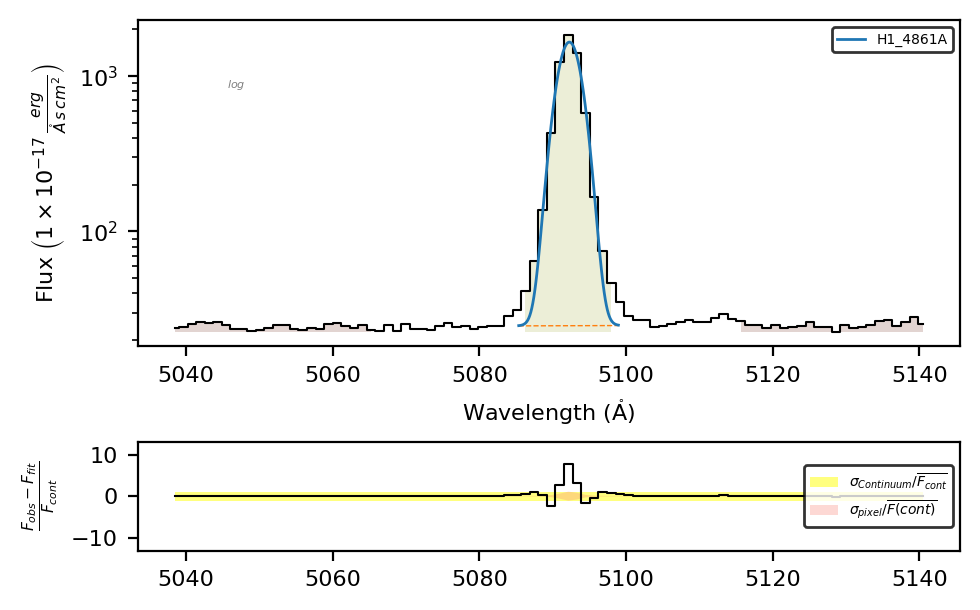

In [2]:
# Plot the line region
spec.plot.bands()

The [measurements](../3_explanations/0_measurements.rst) are stored in the ``Spectrum.frame`` attribute, as a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html):

In [3]:
spec.frame[['profile_flux', 'profile_flux_err', 'amp', 'center', 'sigma']]

,profile_flux,profile_flux_err,amp,center,sigma
H1_4861A,6366.836884,259.600294,1633.726534,5092.268644,1.559019


## Profile and shape:

You can use the [$\mathrm{LiMe}$ notation](2_line_labels.ipynb) to adjust the profile and/or shape of your profile. For example:

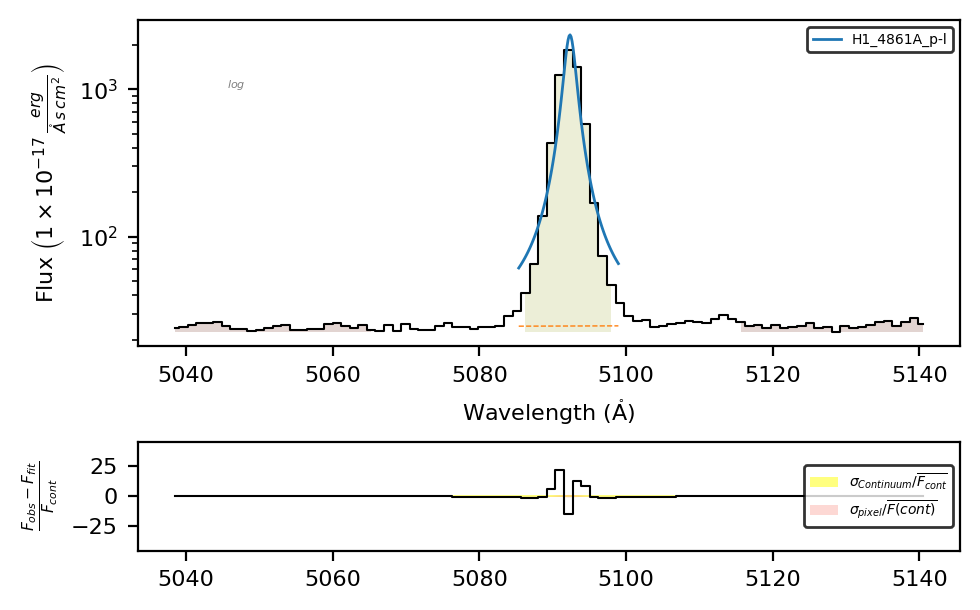

In [4]:
# Lorentz profile fitting
spec.fit.bands('H1_4861A_p-l')
spec.plot.bands()

Or you can use the `shape` and `profile` arguments to set these conditions:

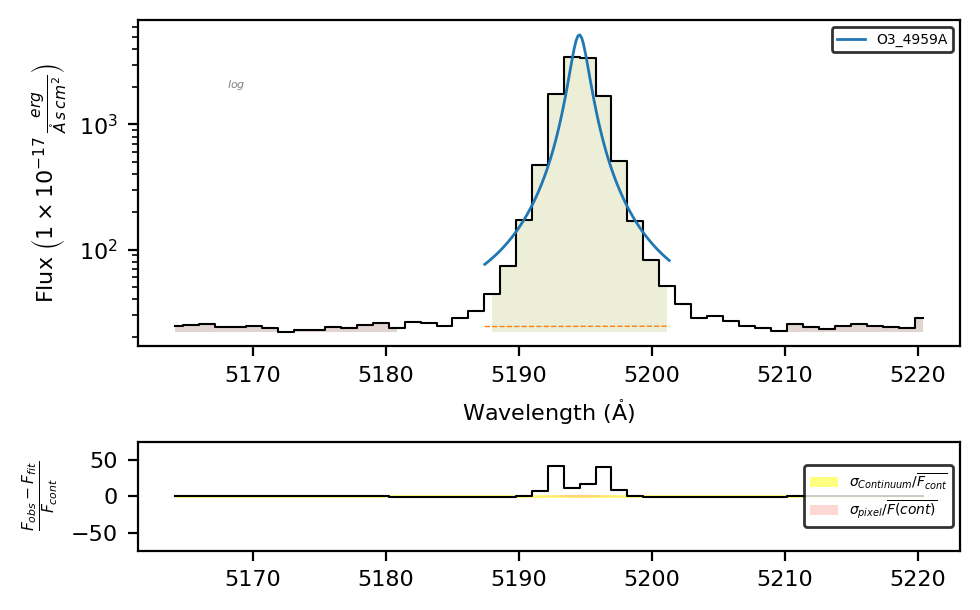

In [5]:
# Lorentz profile fitting
spec.fit.bands('O3_4959A', profile='l')
spec.plot.bands()

<div class="alert alert-success">

**Please note:** The default `shape` and `profile` values in $\mathrm{LiMe}$ are emission (**emi**) and Gaussian (**g**). The priority for deciding the final value of these parameters is: **label suffix** > **configuration file** > **lines table** > `profile/shape` **arguments in the *.fit* functions** > **default values**. To change the default values in the lines database, [check this guide](../1_introduction/4_lines_database.ipynb). 

</div>

You can check the available profiles, their identifying character, and their parameters by running the $\tt{lime.show\_profile\_parameters()}$ function.

In [6]:
lime.show_profile_parameters()


Available profiles (with their identifying character) and their parameters:
- Gaussian "g": ['amp', 'center', 'sigma']
- Lorentzian "l": ['amp', 'center', 'sigma']
- Voigt "v": ['amp', 'center', 'sigma', 'gamma']
- Pseudo-Voigt "pv": ['amp', 'center', 'sigma', 'frac']
- Pseudo-Power law "pp": ['amp', 'center', 'sigma', 'alpha', 'frac']
- Broken Power law "p": ['a', 'b', 'c', 'alpha']
- Exponential "e": ['amp', 'center', 'alpha']


## Multi-profile fitting

By default $\mathrm{LiMe}$ assumes a single component, however, in many cases this is not enough:

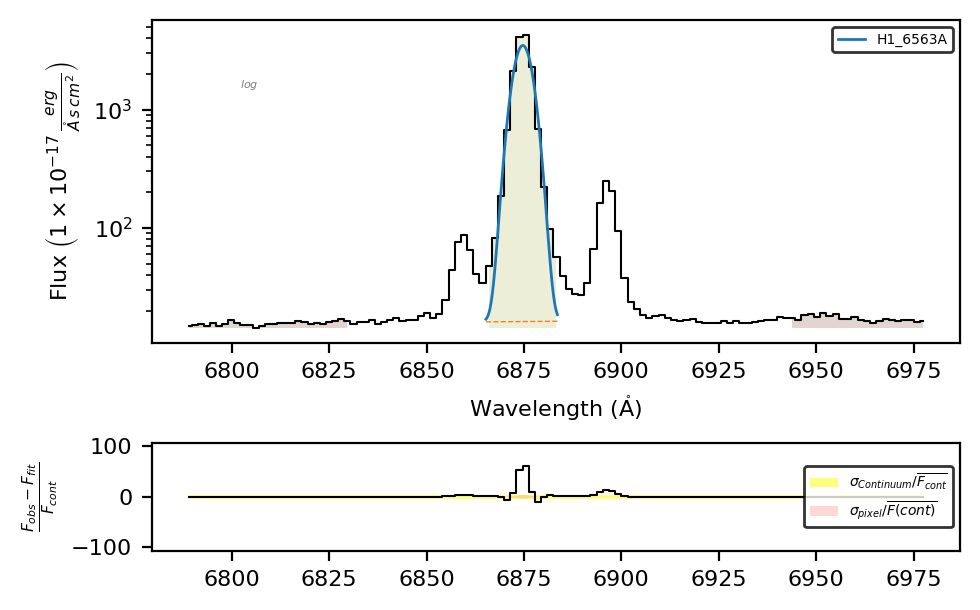

In [7]:
# Fit a line from the default label list
spec.fit.bands('H1_6563A')
spec.plot.bands()

In thi case we, need to fit multiple profiles simultaneously. Let's start by [making a wider band](../1_introduction/2_line_labels.ipynb) for $H\alpha$ and $[NII]6548,6583\mathring{A}$ doublet

In [19]:
band_df = spec.retrieve.lines_frame(line_list=['H1_6563A'], band_vsigma=350)
band_df

,wavelength,wave_vac,w1,w2,w3,w4,w5,w6,latex_label,units_wave,particle,trans,rel_int
H1_6563A,6562.7,6564.61,6480.03,6520.66,6529.488583,6595.911417,6627.7,6661.82,$HI6563\mathring{A}$,Angstrom,H1,rec,1


If we repeat the fitting:

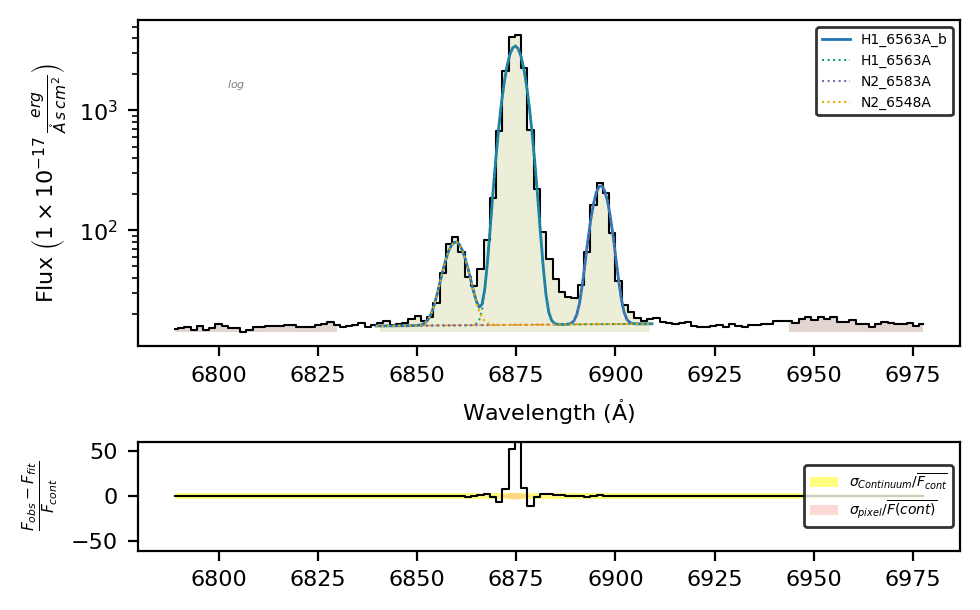

In [20]:
spec.fit.bands('H1_6563A', bands=band_df)
spec.plot.bands()

Now the central band covers the three components. However, only one line was fitted. 

<div class="alert alert-success">

To fit the three components, we need to use the blended **(_b)** suffix and specify the three components in the fitting configuration

</div>



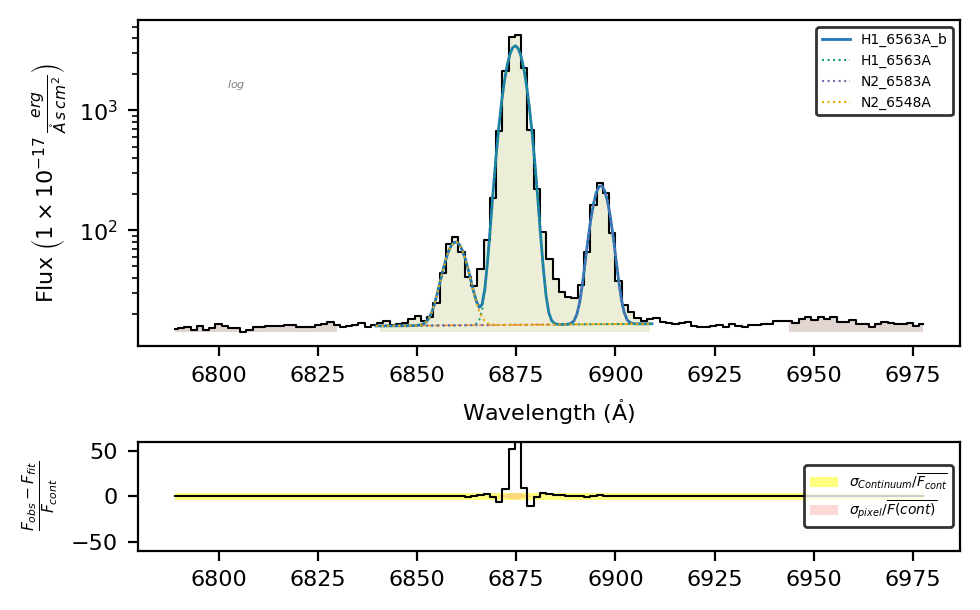

In [21]:
fit_cfg = {'H1_6563A_b': 'H1_6563A+N2_6583A+N2_6548A'}
spec.fit.bands('H1_6563A_b', band_df, fit_cfg)
spec.plot.bands()

This is a better result, now in the measurements frame we have:

In [22]:
spec.frame.loc[['H1_6563A', 'N2_6583A', 'N2_6548A'], ['intg_flux', 'profile_flux']]

,intg_flux,profile_flux
H1_6563A,24898.391058,20099.995447
N2_6583A,24898.391058,1145.227082
N2_6548A,24898.391058,422.176930


<div class="alert alert-warning">

**Please remember:** In de-blended lines, all components share the same integrated flux and uncertainty (``intg_flux`` and ``intg_flux_err``), which are only affected by the pixel values within the central line band. The profile fluxes (``profile_flux`` and ``profile_flux_err``) depend on the fitted profiles of each component.


</div>

## Constrain the profile parameters

In order to adjust the fittings, you can constrain the parameters of the profiles considered. For example, for a Gaussian profile, if the mathematical expression is:

$\mathrm{F_{\lambda}=\sum_{i}A_{i}e^{-\left(\frac{\lambda-\mu_{i}}{2\sigma_{i}}\right)^{2}} + m{\lambda} + c}$

In the $\mathrm{LiMe}$ configuration language, each parameter is tagged with the line label followed by the parameter abbreviation. For example, in the previous fitting, the $H\alpha$ parameters are:
 * $\tt{H1\_6563A\_amp}$: the line amplitude, i.e., the height of the Gaussian profile above the continuum level $(A_i)$.
 * $\tt{H1\_6563A\_center}$: the observed Gaussian centroid in the spectrum wavelength units $(\mu_i)$.
 * $\tt{H1\_6563A\_sigma}$: the Gaussian profile sigma width in the spectrum wavelength units $(\sigma_i)$.
 * $\tt{H1\_6563A\_cont\_slope}$: the local continuum gradient. In blended lines, there is only one continuum slope, labeled after the first component $(m)$.
 * $\tt{H1\_6563A\_cont\_intercept}$: the linear flux at the blue edge of the central band. In blended lines, there is still only one continuum intercept, labeled after the first component $(c)$.

<div class="alert alert-success">

**Please remember:** Any value for the ``_center`` wavelength must be given in the rest frame; $\mathrm{LiMe}$ will apply the redshift correction. Similarly, the ``_amp`` values must use the same units as the input flux, and $\mathrm{LiMe}$ will apply the normalization.

</div>

LiMe transforms each of these entries into [an LmFIT parameter](https://lmfit.github.io/lmfit-py/parameters.html), which can be constrained using the following arguments:

* ``value``: Initial value of the parameter. $\mathrm{LiMe}$ provides an initial guess for the parameters from the [integrated measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html#integrated-properties).
* ``vary``: Whether the parameter is free during fitting (default is True). If set to *False*, the initial ``value`` remains unchanged.
* ``min``: Lower bound for the parameter value. The default value is -numpy.inf (no lower bound).
* ``max``: Upper bound for the parameter value. The default value is numpy.inf (no upper bound).
* ``expr``: Mathematical expression to constrain the value during fitting. The default value is None.

Let's try some of these parameter constraints:

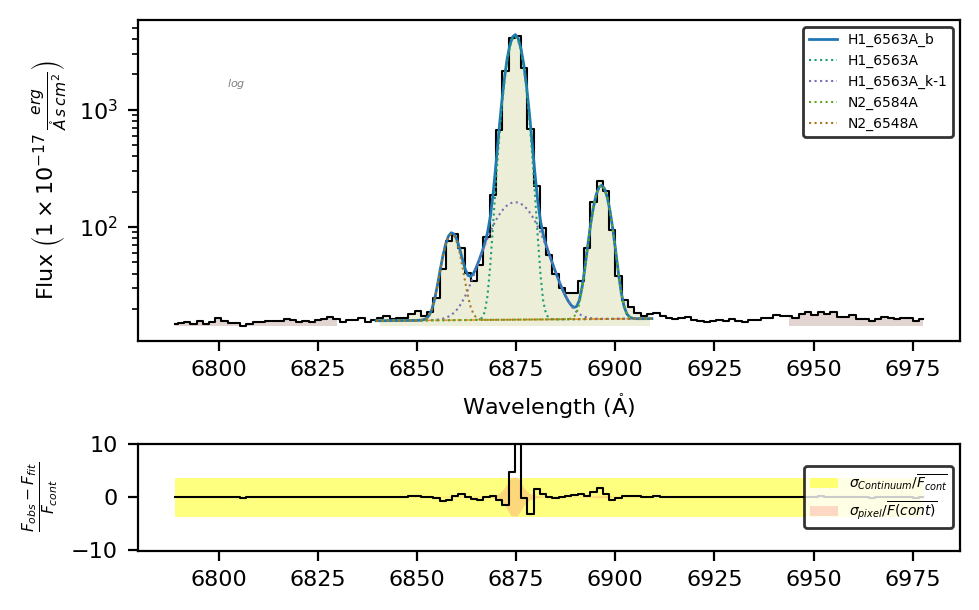

In [24]:
line = 'H1_6563A_b'
fit_conf = {'H1_6563A_b': 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A',        # Line components of the line
            'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},                  # [NII] amplitude constrained by the emissivity ratio
            'N2_6548A_kinem': 'N2_6584A',                                   # Tie the kinematics of the [NII] doublet
            'H1_6563A_k-1_center': {'value':6562, 'min': 6561, 'max':6563}, # Range for the wide Hα value
            'H1_6563A_k-1_sigma': {'expr':'>1.0*H1_6563A_sigma'}}           # Second Hα sigma must be higher than first sigma

# Second attempt including the fit configuration
spec.fit.bands(line, band_df, fit_conf)
spec.plot.bands()

In this fitting, we made several improvements:

* The amplitude ratio of the $[NII]6548,6584\mathring{A}$ lines is set to the theoretical value (2.94). This is done by using ``'expr': 'N2_6584A_amp/2.94'`` to force ``N2_6548A_amp`` to adhere to this relation.

In [28]:
spec.frame.loc['N2_6584A', 'amp']/spec.frame.loc['N2_6548A', 'amp']

np.float64(2.94)

* The nitrogen doublet is constrained to have the same kinematics by using ``'N2_6548A_kinem': 'N2_6584A'``.

In [26]:
spec.frame.loc[['N2_6584A', 'N2_6548A'], ['v_r', 'sigma_vel']]

,v_r,sigma_vel
N2_6584A,-11.384383,89.782577
N2_6548A,-11.383259,89.782577


* We added a kinematic component to $H\alpha$ (``H1_6563A_k-1``). The sigma of this component is larger, thanks to the ``'H1_6563A_k-1_sigma': {'expr':'>1.0*H1_6563A_sigma'}`` term.

In [27]:
spec.frame.loc[['H1_6563A', 'H1_6563A_k-1'], 'sigma']

H1_6563A        1.990655
H1_6563A_k-1    5.415842
Name: sigma, dtype: float64

* The sigma of the wide component has a user-defined initial value and is constrained to 1 Å via the ``'H1_6563A_k-1_center': {'value':6562, 'min': 6561, 'max':6563}`` term.

## Failed fittings

Depending on the complexity of the fitting, the minimizer may fail to converge. In this case, the profile lines will be displayed in red:

In [ ]:
line = 'H1_6563A_b'
fit_conf = {'H1_6563A_b': 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A'} 
spec.fit.bands(line, band_df, fit_conf)
spec.plot.bands()

The uncertainty of the profile components will be ``np.nan``:

In [ ]:
spec.frame.loc[['H1_6563A', 'H1_6563A_k-1'], ['profile_flux', 'profile_flux_err', 'amp', 'amp_err', 'center', 'center_err', 'sigma', 'sigma_err']]

To fix a failed fitting, you can add more constraints on the parameters. To gain better insight into the causes behind the failed fitting, you can access the [LmFIT report](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.fit_report) via ``.fit.report()``:

In [29]:
spec.fit.report()

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 202
    # data points      = 93
    # variables        = 9
    chi-square         = 1060.13884
    reduced chi-square = 12.6207004
    Akaike info crit   = 244.320677
    Bayesian info crit = 267.114072
    R-squared          = 0.99885619
[[Variables]]
    H1_6563A_m_cont:      0.009730538 (fixed)
    H1_6563A_n_cont:     -50.68299 (fixed)
    H1_6563A_amp:         4212.99034 +/- 128.397881 (3.05%) (init = 4267.743)
    H1_6563A_center:      6874.68964 +/- 0.02870170 (0.00%) (init = 6874.428)
    H1_6563A_sigma:       1.99065506 +/- 0.02729887 (1.37%) (init = 3.165993)
    H1_6563A_k-1_amp:         146.603191 +/- 18.4131819 (12.56%) (init = 4267.743)
    H1_6563A_k-1_center:      6874.74250 +/- 0.14196693 (0.00%) (init = 6873.695)
    H1_6563A_k-1_sigma:       5.41584202 +/- 0.23339731 (4.31%) == 'H1_6563A_k-1_sigma_ineq*H1_6563A_sigma'
    N2_6584A_amp:         210.395760 +/- 6.96467614 (3.31%) (init = 

We can see in this report that there is a large change between the initial centers for the $H\alpha$ components:


```
H1_6563A_center:  16599.3998 (init = 6874.448)
H1_6563A_k-1_center: -2850.16426 (init = 6874.448)
```

This means that you should apply stronger constraints to these parameters.

<div class="alert alert-info">

**Please remember:** Once we start fitting profiles with more than 10 dimensions (for example, four Gaussian components), traditional minimizers are very sensitive to the boundary conditions and cannot explore the parameter space efficiently. Future $\mathrm{LiMe}$ upgrades will explore more advanced samplers to automatically determine the number of components and estimate the distributions of parameter values.

</div>


## Loading the fitting configuration from a text file

In most cases, you will be interested in fitting multiple lines from multiple spectra. To simplify typing the configuration entries, it is recommended that you put your configuration into a text file using the [.toml configuration format](https://toml.io/en/) and use that as input for your ``.fit`` functions.

For example, let's save the previous configuration to a text file:

In [45]:
fit_cfg_str = """[default_line_fitting]
H1_6563A_b = 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A'
N2_6548A_amp = 'expr:N2_6584A_amp/2.94'
N2_6548A_kinem = 'N2_6584A'
H1_6563A_k-1_center = 'value:6562,min:6561,max:6563'
H1_6563A_k-1_sigma = 'expr:>1.0*H1_6563A_sigma'
"""

# Save to file while keeping line breaks
with open("../0_resources/results/Halpha_cfg.toml", "w", encoding="utf-8") as file:
    file.write(fit_cfg_str)

This produces a '.toml' file, which can be read using the $\tt{lime.load\_cfg}$ function:

In [46]:
fit_cfg = lime.load_cfg("../0_resources/results/Halpha_cfg.toml")
fit_cfg

{'default_line_fitting': {'H1_6563A_b': 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A',
  'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
  'N2_6548A_kinem': 'N2_6584A',
  'H1_6563A_k-1_center': {'value': 6562.0, 'min': 6561.0, 'max': 6563.0},
  'H1_6563A_k-1_sigma': {'expr': '>1.0*H1_6563A_sigma'}}}

When the $\tt{lime.load\_cfg}$ function finds a ``[section]`` with ``_line_fitting``, it formats the entries to match the expected $\mathrm{LiMe}$ style. This way, you don't need to type the **"{"** and **"}"** characters (but you must avoid white spaces and put all item values between **' '**).  

This dictionary can be passed directly to the fitting function:


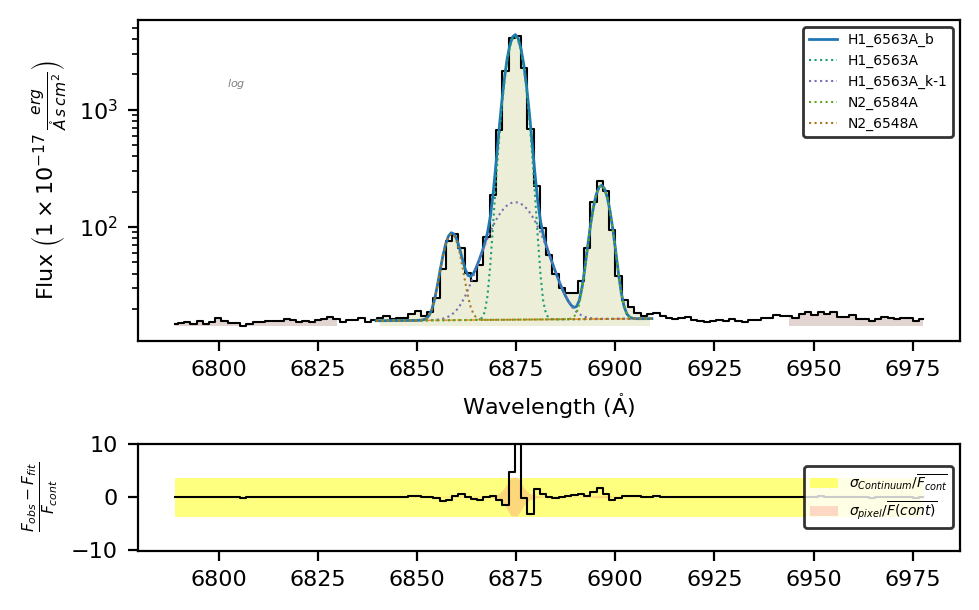

In [47]:
line = 'H1_6563A_b'
spec.fit.bands(line, band_df, fit_cfg)
spec.plot.bands()

Alternatively, we can directly provide the text file path (this also applied to the line bands frame):

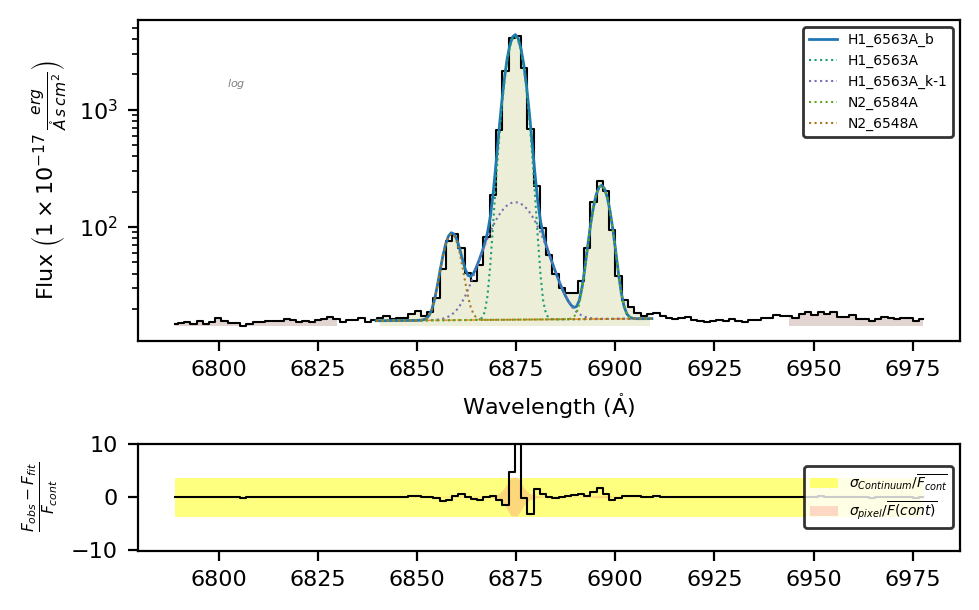

In [49]:
line = 'H1_6563A_b'
spec.fit.bands(line, band_df, "../0_resources/results/Halpha_cfg.toml")
spec.plot.bands()

## Save the results

$\mathrm{LiMe}$ can save the results into different formats using the $\tt{lime.Spectrum.save\_frame}$ function:

In [50]:
# Save to a text file
spec.save_frame('../0_resources/results/example1_linelog.txt')

Additional file formats allow the user to save the current data to a specific page:

In [51]:
spec.save_frame('../0_resources/results/example1_linelog.fits', page='SHOC579')
spec.save_frame('../0_resources/results/example1_linelog.xlsx', page='SHOC579')

Finally, if you have latex and pylatex installed on your system you can also save the results as a pdf file:

In [52]:
spec.save_frame('../0_resources/results/example1_linelog.pdf', param_list=['eqw', 'profile_flux', 'profile_flux_err'])

The argument ``param_list`` constrains the output measurements to the input list.

## Takeaways

* By default, $\mathrm{LiMe}$ fits a Gaussian profile to a line. You can change this using the line notation, the `profile`/`shape` arguments in the $\tt{.fit}$ functions, the input bands table, or [the default lines database](../1_introduction/4_lines_database.ipynb).
* To fit multiple components to a line, you need to add the [blended suffix to the line label](../1_introduction/2_line_labels.ipynb) (for example, ``H1_6563A_b``) and include its components in the fitting configuration (for example, ``H1_6563A_b='H1_6563A+N2_6585A+N2_6548A'``).
* You can constrain the components' profile parameters using the $\tt{value}$, $\tt{min}$, $\tt{max}$, $\tt{expr}$, and $\tt{vary}$ attributes in the configuration (for example, ``'expr:>1.0*H1_6563A_sigma'``).
* For very complex profiles (4 components or more), the minimizer is very sensitive to the initial boundary conditions, and some tinkering may be necessary in the current algorithm version to successfully fit these profiles.
* It is recommended to save your profile settings in a .toml file and input them into the fitting functions. As long as the corresponding ``[section]`` has the ``_line_fitting`` suffix, the entries will be formatted to the expected structure. If no section name is provided, $\mathrm{LiMe}$ will use the data from the ``[default_line_fitting]`` section.